In [57]:
# data from 
# https://www.kaggle.com/datasets/alanchn31/free-spoken-digits

# check this out
# https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial


In [58]:
# train the GMM on the concatenated MFCC features
import os
import re
import random
random.seed(0)

person_num = 3
test_samples = 10

paths = os.listdir('../data/recordings/')
random.shuffle(paths)

# extracts all the people names in the dataset
people = list(set([" ".join(re.findall("[a-zA-Z]+", "".join(x.split('.')[0:-1]))) for x in paths]))
people.sort()

# add relative path
paths = ['../data/recordings/'+x for x in paths]

print(f'Training on {people[person_num]}')

Training on nicolas


In [59]:
# Testing with alternative larger and more interesting dataset
import os
import numpy as np
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile

# directory containing the training data files
one_person_paths = [x for x in paths if people[person_num] in x]
train_paths = one_person_paths[0:-test_samples]
test_paths = one_person_paths[-test_samples:]

# create a GMM with n components
n = 500
gmm = GaussianMixture(n_components=n)

# loop over each audio file in the data directory
mfcc_features = None
for file_path in train_paths:
    sample_rate, audio_data = wavfile.read(file_path)
    
    # compute MFCC features for the audio data
    mfcc_data = mfcc(audio_data, sample_rate)
    
    # concatenate the MFCC features into a single numpy array
    if mfcc_features is None:
        mfcc_features = mfcc_data
    else:
        mfcc_features = np.concatenate((mfcc_features, mfcc_data), axis=0)
# train the GMM on the concatenated MFCC features
gmm.fit(mfcc_features)

GaussianMixture(n_components=500)

In [60]:
person_scores = []

for person in people:
    if person == people[person_num]:
        person_paths = test_paths
    else:
        person_paths = random.sample([x for x in paths if person  in x], test_samples)

    individual_scores = [] 
    for path in person_paths:
        sample_rate, test_data = wavfile.read(path)
        mfcc_data = mfcc(test_data, sample_rate, numcep=13)
        score = gmm.score(mfcc_data)
        individual_scores.append(score)
    person_scores.append(individual_scores)

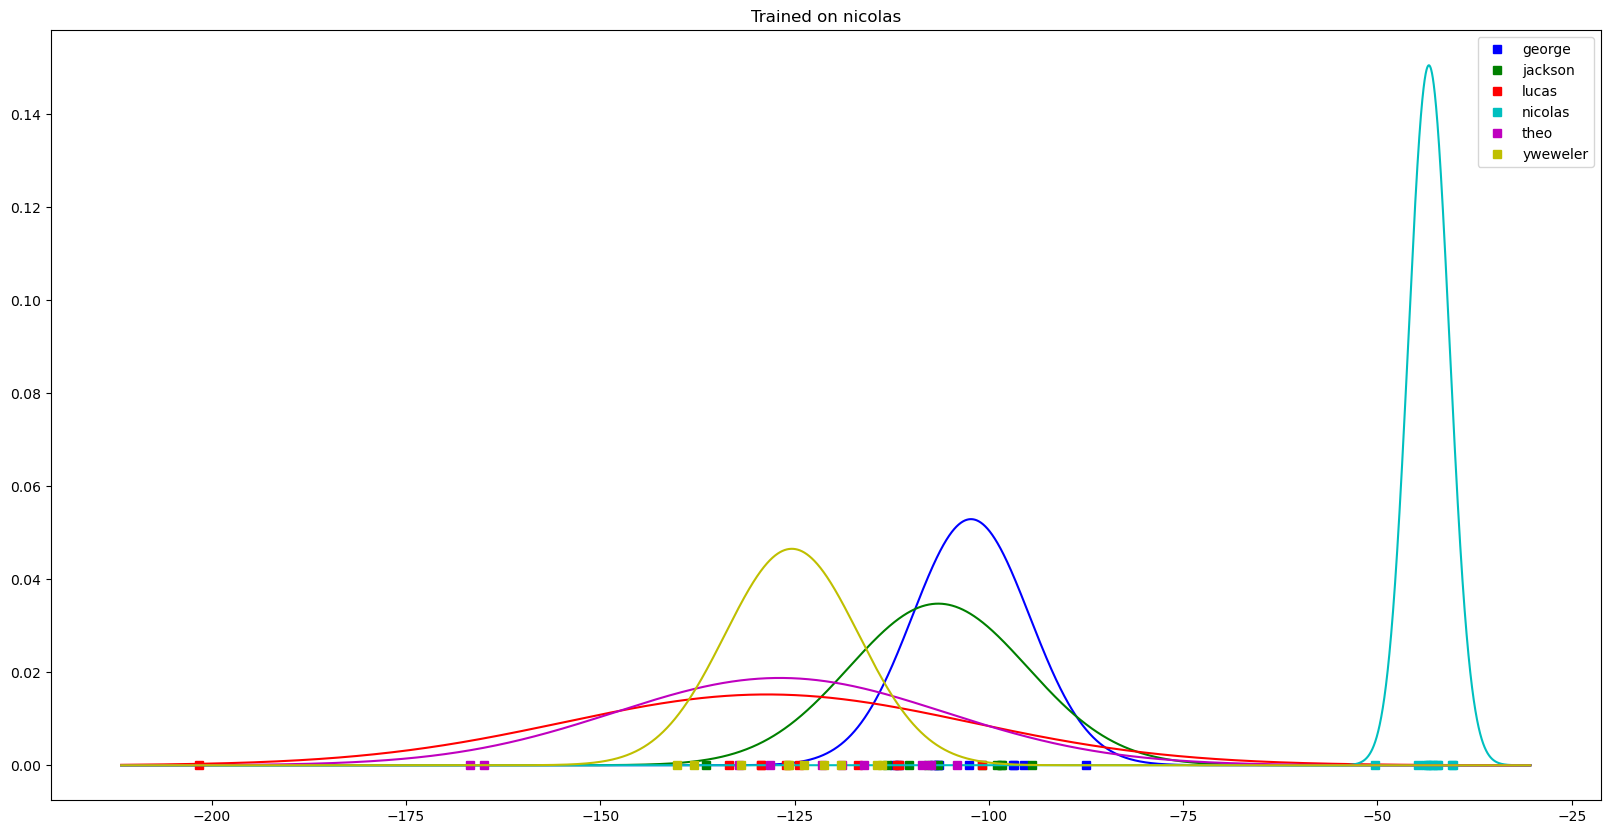

In [61]:
import matplotlib.pyplot as plt
from scipy.stats import norm

lowest_value = min([min(x) for x in person_scores])
highest_value = max([max(x) for x in person_scores])

plt.figure(figsize=(20,10))
x = np.arange(lowest_value-10, highest_value+10, 0.01)

for idx,person in enumerate(people):
    aProb = norm.pdf(x, loc=np.mean(person_scores[idx]), scale=np.std(person_scores[idx]))
    plt.plot(x, aProb, ['b', 'g', 'r', 'c', 'm', 'y'][idx])
    plt.plot(person_scores[idx], np.zeros(len(person_scores[idx])), ['b', 'g', 'r', 'c', 'm', 'y'][idx]+'s', lw=2, label=person)
    plt.legend();
    plt.title(f'Trained on {people[person_num]}');

plt.show()